**List 6** - Algorithms and Data Structures 2021/22, WUST - F13

*Author:* Mateusz Machaj, 262288

*Date:* 10.01.2022

# Import

In [1]:
from __future__ import annotations

import operator
import string
import time
from typing import Any, List, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

-----------------------

# Task 1

_**Binary search tree class implementation**_

-----------------------

Implementation is written basing on the professor's lecture notes [[1]](#ref1), but some elements are modified - especially handling duplicate keys and issues regarding PEP rules. There were also a couple of mistakes to correct.

I do not use unncessary `get` and `set` methods for attributes, because the code is written with respect to *python* conventions.

## Node class

At first I create a node class representing each unit in binary tree. 

In [2]:
class TreeNode:
    """Binary tree node class giving all the info about properities and setting new data."""

    def __init__(
        self,
        key: int,
        value: Any = None,
        parent: TreeNode = None,
        left_ch: TreeNode = None,
        right_ch: TreeNode = None,
    ):
        """Create new node and evaluate height of it as a subtree root.

        Args:
            key (int): Node's key.
            value (Any, optional): Node's value. Defaults to None.
            parent (TreeNode, optional): Parent of the node. Defaults to None.
            left_ch (TreeNode, optional): Left child of the node. Defaults to None.
            right_ch (TreeNode, optional): Right child of the node. Defaults to None.
        """
        self.key = key
        self.value = value
        self.parent = parent
        self.left_ch = left_ch
        self.right_ch = right_ch

        self.height = 1
        self.eval_height()  # used only for AVL Tree

    def is_root(self) -> bool:
        """Tell if the node is the main root of the tree.

        Returns:
            bool: Info about being a general root.
        """
        return not self.parent

    def is_left_ch(self) -> bool:
        """Tell if the node is left child of some other node.

        Returns:
            bool: Info about being a left child.
        """
        return self.parent and self.parent.left_ch is self

    def is_right_ch(self) -> bool:
        """Tell if the node is right child of some other node.

        Returns:
            bool: Info about being a right child.
        """
        return self.parent and self.parent.right_ch is self

    def has_left_ch(self) -> bool:
        """Tell if the node has a left child.

        Returns:
            bool: Info about having a left child.
        """
        return self.left_ch

    def has_right_ch(self) -> bool:
        """Tell if the node has a right child.

        Returns:
            bool: Info about having a right child.
        """
        return self.right_ch

    def children_number(self) -> int:
        """Check the number of node's children.

        Returns:
            int: Number of children.
        """
        if self.left_ch and self.right_ch:
            return 2
        elif not (self.left_ch or self.right_ch):
            return 0
        else:
            return 1

    def is_leaf(self) -> bool:
        """Check if node has any children (if not it is a "leaf").

        Returns:
            bool: Info about having any children.
        """
        return not bool(self.children_number())

    def get_item_data(self) -> Tuple[int, Any]:
        """Get node's key and a proper value.

        Returns:
            Tuple[int, Any]: Item key and value.
        """
        return self.key, self.value

    def set_item_data(self, key: int, value: Any = None):
        """Set new key and value for a node.

        Args:
            key (int): New key.
            value (Any, optional): New value. Defaults to None.
        """
        self.key = key
        self.value = value

    def get_children(self) -> Tuple[TreeNode, TreeNode]:
        """Find node's children.

        Returns:
            Tuple[TreeNode, TreeNode]: Children refernces.
        """
        return self.left_ch, self.right_ch

    def get_children_heights(self) -> Tuple[int, int]:
        """Find heights of left and right subtrees of the node.
        Height is a number of levels below until the tree ends (nodes have no more children); it is counted along with the base node.

        Returns:
            Tuple[int, int]: Subtrees heights.
        """
        if self.left_ch:
            left_height = self.left_ch.height
        else:
            left_height = 0
        if self.right_ch:
            right_height = self.right_ch.height
        else:
            right_height = 0
        return left_height, right_height

    def eval_height(self):
        """Recalculate the height of a current node."""
        left_height, right_height = self.get_children_heights()
        own_height = 1 + max(left_height, right_height)
        self.height = own_height

    def set_children(self, left_ch: TreeNode = False, right_ch: TreeNode = False):
        """Set new children to a real child or `None` - if it is required to delete some.
        Recalculate the heights and take care about parent-children relation service (also in peculiar cases).

        Args:
            left_ch (TreeNode, optional): New left child. Defaults to False.
            right_ch (TreeNode, optional): New right child. Defaults to False.
        """
        if not left_ch is False:
            self.left_ch = left_ch
            if self.parent == left_ch:
                if left_ch:
                    self.parent = left_ch.parent
                else:
                    self.parent = None
            if left_ch:
                self.left_ch.parent = self
            self.eval_height()
            node = self
            while node.parent:
                node.parent.eval_height()
                node = node.parent

        if not right_ch is False:
            self.right_ch = right_ch
            if self.parent == right_ch:
                if right_ch:
                    self.parent = right_ch.parent
                else:
                    self.parent = None
            if right_ch:
                self.right_ch.parent = self
            self.eval_height()
            node = self
            while node.parent:
                node.parent.eval_height()
                node = node.parent

    def get_balance_fact(self) -> int:
        """Find the node's balance factor - difference between subtrees heights.

        Returns:
            int: Balance factor.
        """
        left_height, right_height = self.get_children_heights()
        balance_fact = left_height - right_height
        return balance_fact

## Main tree class

Now, the main binary search tree class.

I assume that **repeated keys are not allowed** [[2]](#ref2). It means that left children are strictly smaller and right - strictly greater (unlike in the lecture notes).

In [3]:
class BSTree:
    """Basic binary search tree with a neat `str` representation added.
    It allows to use python set `[]`, get `[]`, `del` key, `str`, `in` and `len` "operators".
    """

    def __init__(self):
        """Create a new BS tree without nodes."""
        self.root = None
        self.size = 0

    def length(self) -> int:
        """Find tree size - number if nodes.

        Returns:
            int: Tree size.
        """
        return self.size

    def __len__(self) -> int:
        """Find tree size - number if nodes. Handle the special operator usage.

        Returns:
            int: Tree size.
        """
        return self.size

    def _put(self, key: int, value: Any, current_node: TreeNode):
        """A helper function.
        Add a new node as a children in appropriate place or change the one with the same key.

        Args:
            key (int): New node's key.
            value (Any): New node's value.
            current_node (TreeNode): The node to start place searching for the new node.
        """
        if key < current_node.key:
            if current_node.has_left_ch():
                self._put(key, value, current_node.left_ch)
            else:
                current_node.set_children(left_ch=TreeNode(key, value))
        elif key > current_node.key:
            if current_node.has_right_ch():
                self._put(key, value, current_node.right_ch)
            else:
                current_node.set_children(right_ch=TreeNode(key, value))
        elif key == current_node.key:
            current_node.value = value

    def put(self, key: int, value: Any = None):
        """Add new node (or change one) and adjust the tree size.

        Args:
            key (int): New node's key.
            value (Any): New node's value. Defaults to None.

        Raises:
            TypeError: Raised when the given key is not an integer.
        """
        if not isinstance(key, int):
            raise TypeError("Key have to be an integer.")
        if self.root:
            self._put(key, value, self.root)
        else:
            self.root = TreeNode(key, value)
        self.size += 1

    def put_nv_list(self, key_list: List[int]):
        """Add or replece nodes with keys from the list. Leave their values as `None`.
        Use `put` method for each.

        Args:
            key_list (List[int]): List of node keys to be added.
        """
        for key in key_list:
            self.put(key)

    def __setitem__(self, key: int, value: Any):
        """Add or change the node using special set operator.

        Args:
            key (int): New node's key.
            value (Any): New node's value.
        """
        self.put(key, value)

    def _get(self, key: int, current_node: TreeNode = None) -> TreeNode:
        """A helper function.
        Get a value of the node with the given key starting from the given place.

        Args:
            key (int): Key of the node which value is requested.
            current_node (TreeNode, optional): Node to start searching from. Defaults to None.

        Raises:
            KeyError: Raised with the key is not in the tree.

        Returns:
            TreeNode: Value of a node with the given key.
        """
        if not current_node:
            current_node = self.root
        if key < current_node.key:
            if current_node.has_left_ch():
                return self._get(key, current_node.left_ch)
            else:
                raise KeyError("Key not found.")
        elif key > current_node.key:
            if current_node.has_right_ch():
                return self._get(key, current_node.right_ch)
            else:
                raise KeyError("Key not found.")
        elif key == current_node.key:
            return current_node

    def get(self, key: int) -> Any:
        """Get a value of the node with the given key.

        Args:
            key (int): Key of the node which value is requested.

        Raises:
            Exception: No nodes with values in an ampty tree.

        Returns:
            Any: Value of a node with the given key.
        """
        if self.root:
            search_res = self._get(key, self.root)
            return search_res.value
        else:
            raise Exception("Tree is empty. Cannot find the key.")

    def __getitem__(self, key: int) -> Any:
        """Get a value of the node with the given key using special get operator.

        Args:
            key (int): Key of the node which value is requested.

        Returns:
            Any: Value of a node with the given key.
        """
        return self.get(key)

    def __contains__(self, key: int) -> bool:
        """Check if the tree contains a node with the given key.

        Args:
            key (int): Key to check the presence.

        Returns:
            bool: Info about presence.
        """
        if self._get(key, self.root):
            return True
        else:
            return False

    def _find_min(self, current_node: TreeNode = None) -> TreeNode:
        """Find a node with the minimal key. Start from the given place.

        Args:
            current_node (TreeNode, optional): Node to start searching from. Defaults to None.

        Returns:
            TreeNode: Minimal node.
        """
        if not current_node:
            current_node = self.root
        while current_node.has_left_ch():
            current_node = current_node.left_ch
        return current_node

    def first_item(self) -> Tuple[int, Any]:
        """Get the items of the node with a minimal key.

        Returns:
            Tuple[int, Any]: Key and value of the minimal node.
        """
        min_key_node = self._find_min()
        return (min_key_node.key, min_key_node.value)

    def _find_max(self, current_node: TreeNode = None) -> TreeNode:
        """Find a node with the maximal key. Start from the given place.

        Args:
            current_node (TreeNode, optional): Node to start searching from. Defaults to None.

        Returns:
            TreeNode: Maximal node.
        """
        if not current_node:
            current_node = self.root
        while current_node.has_right_ch():
            current_node = current_node.right_ch
        return current_node

    def last_item(self) -> Tuple[int, Any]:
        """Get the items of the node with a maximal key.

        Returns:
            Tuple[int, Any]: Key and value of the maximal node.
        """
        max_key_node = self._find_max()
        return (max_key_node.key, max_key_node.value)

    def _find_successor(self, current_node: TreeNode = None) -> Optional[TreeNode]:
        """Find the next ("successor") node - the one with the smallest key greater by the current's one.

        Args:
            current_node (TreeNode, optional): Node to find the "successor" for. Defaults to None.

        Returns:
            Optional[TreeNode]: "Successor" node.
        """
        if not current_node:
            current_node = self.root
        succ = None
        if current_node.has_right_ch():
            succ = self._find_min(current_node.right_ch)
        else:
            if not current_node.is_root():
                if current_node.is_left_ch():
                    succ = current_node.parent
                else:
                    current_node.parent.right_ch = None
                    succ = self._find_successor(current_node.parent)
                    current_node.parent.right_ch = current_node
        return succ

    def _remove(self, current_node: TreeNode):
        """Remove the given node and fix the order in the tree.
        Consider all cases of removing.

        Args:
            current_node (TreeNode): Node to remove.

        Raises:
            Exception: Root "successor" cannot be found for some reason. Cannot remove the node.
        """
        if current_node.is_leaf():
            if current_node.is_left_ch():
                current_node.parent.set_children(left_ch=None)
            else:
                current_node.parent.set_children(right_ch=None)
        elif current_node.children_number() == 2:
            succ = self._find_successor(current_node)
            if not succ:
                raise Exception("Successor searching error.")
            current_node.set_item_data(*succ.get_item_data())
            self._remove(succ)

        else:
            if current_node.has_left_ch():
                child = current_node.left_ch
            else:
                child = current_node.right_ch

            if current_node.is_left_ch():
                current_node.parent.set_children(left_ch=child)
            elif current_node.is_right_ch():
                current_node.parent.set_children(right_ch=child)
            else:
                current_node.set_item_data(*child.get_item_data())
                current_node.set_children(*child.get_children())

    def delete(self, key: int):
        """Delete a node with the given key.
        Use fixing tools to keep the proper order in the tree.

        Args:
            key (int): Key of the node to delete.

        Raises:
            KeyError: Key is not in the tree.
            Exception: No nodes to delete in an ampty tree.
        """
        if self.size > 1:
            current_node = self._get(key)
            if current_node:
                self._remove(current_node)
                self.size -= 1
            else:
                raise KeyError("Key not found.")
        elif self.size == 1 and self.root.key == key:
            self.root = None
            self.size -= 1
        else:
            raise Exception("Tree is empty. Cannot find the key.")

    def __delitem__(self, key: int):
        """Delete a node with the given key using special deletion operator.

        Args:
            key (int): Key of the node to delete.
        """
        self.delete(key)

    def __str__(self) -> str:
        """Prepare a simple text representation for printing the tree.
        Show only structure and keys. No values.

        Returns:
            str: Tree ascii representation.
        """
        expr_list = []

        def preorder(node, tab_cnt):
            if node:
                expr_list.append("|   " * (tab_cnt - 1))
                expr_list.append("|>>>" * bool(tab_cnt))
                expr_list.append(node.key)
                expr_list.append("\n")
                tab_cnt += 1
                if node.left_ch or node.right_ch:
                    preorder(node.left_ch, tab_cnt)
                    preorder(node.right_ch, tab_cnt)
                    tab_cnt -= 1
            else:
                expr_list.append("|   " * (tab_cnt - 1))
                expr_list.append("|." * bool(tab_cnt))
                expr_list.append("\n")
                tab_cnt += 1
            tab_cnt -= 1

        preorder(self.root, 0)
        str_repr = "".join(map(str, expr_list))
        return str_repr

While using the class only with the methods provided there are no issues with double keys. Changing any values manually causes many problems and creates ambiguous situation in key set. I do not handle this for obvious reasons. In other languages external inaccessibility of attributes solves it. In *python* we assume reasonable usage.

## AVL Tree

Having the basic *binary search tree* class, we can also implement *AVL tree* - as it is done in notes [[1]](#ref1), so by inheritance. This is going to be our final product.

In [4]:
class AVLTree(BSTree):
    """Improved binary search tree. It balances its structure after each operation.

    Args:
        BSTree ([type]): [description]
    """

    def _rotate_left(self, rot_root: TreeNode):
        """Left rotating of some subtree to provide a balance.

        Args:
            rot_root (TreeNode): Root for a rotation - first imbalanced node.
        """
        new_root = rot_root.right_ch
        rot_root.set_children(right_ch=new_root.left_ch)
        if not rot_root.is_root():
            if rot_root.is_left_ch():
                rot_root.parent.set_children(left_ch=new_root)
            else:
                rot_root.parent.set_children(right_ch=new_root)
        else:
            self.root = new_root
        new_root.set_children(left_ch=rot_root)

    def _rotate_right(self, rot_root: TreeNode):
        """Right rotating of some subtree to provide a balance.

        Args:
            rot_root (TreeNode): Root for a rotation - first imbalanced node.
        """
        new_root = rot_root.left_ch
        rot_root.set_children(left_ch=new_root.right_ch)
        if not rot_root.is_root():
            if rot_root.is_left_ch():
                rot_root.parent.set_children(left_ch=new_root)
            else:
                rot_root.parent.set_children(right_ch=new_root)
        else:
            self.root = new_root
        new_root.set_children(right_ch=rot_root)

    def _rebalance(self, current_node: TreeNode):
        """A helper function.
        Use rotations to bring the balance back.

        Args:
            current_node (TreeNode): Root for rotations - the imbalanced node.
        """
        if current_node.get_balance_fact() < 0:
            if current_node.right_ch.get_balance_fact() > 0:
                self._rotate_right(current_node.right_ch)
                self._rotate_left(current_node)
            else:
                self._rotate_left(current_node)
        elif current_node.get_balance_fact() > 0:
            if current_node.left_ch.get_balance_fact() < 0:
                self._rotate_left(current_node.left_ch)
                self._rotate_right(current_node)
            else:
                self._rotate_right(current_node)

    def _update_balance(self, current_node: TreeNode):
        """Update node's subtree balance by finding a proper pivot and - if needed - rebalancing some part of the tree.
        `_rebalance` method is used to bring back the balance.

        Args:
            current_node (TreeNode): Node to update its balance.
        """
        if abs(current_node.get_balance_fact()) > 1:
            self._rebalance(current_node)
        elif not current_node.is_root():
            if current_node.parent.get_balance_fact() != 0:
                self._update_balance(current_node.parent)

    def _put(self, key: int, value: Any, current_node: TreeNode):
        """A helper function.
        Add a new node as a children in appropriate place or change the one with the same key.
        Update the balance too.

        Args:
            key (int): New node's key.
            value (Any): New node's value.
            current_node (TreeNode): The node to start place searching for the new node.
        """
        if key < current_node.key:
            if current_node.has_left_ch():
                self._put(key, value, current_node.left_ch)
            else:
                current_node.set_children(left_ch=TreeNode(key, value))
                self._update_balance(current_node.left_ch)
        elif key > current_node.key:
            if current_node.has_right_ch():
                self._put(key, value, current_node.right_ch)
            else:
                current_node.set_children(right_ch=TreeNode(key, value))
                self._update_balance(current_node.right_ch)
        elif key == current_node.key:
            current_node.value = value

    def _remove(self, current_node: TreeNode):
        """Remove the given node and fix the order in the tree.
        Consider all cases of removing.
        Update the balance too.

        Args:
            current_node (TreeNode): Node to remove.

        Raises:
            Exception: Root "successor" cannot be found for some reason. Cannot remove the node.
        """
        if current_node.is_leaf():
            parent_node = current_node.parent
            if current_node.is_left_ch():
                parent_node.set_children(left_ch=None)
            else:
                parent_node.set_children(right_ch=None)
            self._update_balance(parent_node)
        elif current_node.children_number() == 2:
            succ = self._find_successor(current_node)
            if not succ:
                raise Exception("Successor searching error.")
            current_node.set_item_data(*succ.get_item_data())
            self._remove(succ)

        else:
            parent_node = current_node.parent
            if current_node.has_left_ch():
                child = current_node.left_ch
            else:
                child = current_node.right_ch

            if current_node.is_left_ch():
                parent_node.set_children(left_ch=child)
                self._update_balance(parent_node)
            elif current_node.is_right_ch():
                parent_node.set_children(right_ch=child)
                self._update_balance(parent_node)
            else:
                current_node.set_item_data(*child.get_item_data())
                current_node.set_children(*child.get_children())
                self._update_balance(current_node)

## Presentation

I will start wit a basic *binary search tree*. After adding new elements it is not balanced.

In [5]:
bst = BSTree()
bst.put_nv_list([1, 2, 3, 4, 5, 6, 7, 8])

In [6]:
print(bst)

1
|.
|>>>2
|   |.
|   |>>>3
|   |   |.
|   |   |>>>4
|   |   |   |.
|   |   |   |>>>5
|   |   |   |   |.
|   |   |   |   |>>>6
|   |   |   |   |   |.
|   |   |   |   |   |>>>7
|   |   |   |   |   |   |.
|   |   |   |   |   |   |>>>8



Whereas, *AVL tree* balances the distribution on the fly:

In [7]:
avlt = AVLTree()
avlt.put_nv_list([1, 2, 3, 4, 5, 6, 7, 8])

In [8]:
print(avlt)

4
|>>>2
|   |>>>1
|   |>>>3
|>>>6
|   |>>>5
|   |>>>7
|   |   |.
|   |   |>>>8



All kinds of deletions also work:

In [9]:
del avlt[8]

In [10]:
print(avlt)

4
|>>>2
|   |>>>1
|   |>>>3
|>>>6
|   |>>>5
|   |>>>7



In [11]:
avlt.put_nv_list([9, 8, 10])

In [12]:
del avlt[5]

In [13]:
print(avlt)

4
|>>>2
|   |>>>1
|   |>>>3
|>>>8
|   |>>>6
|   |   |.
|   |   |>>>7
|   |>>>9
|   |   |.
|   |   |>>>10



In [14]:
del avlt[6]

In [15]:
print(avlt)

4
|>>>2
|   |>>>1
|   |>>>3
|>>>8
|   |>>>7
|   |>>>9
|   |   |.
|   |   |>>>10



Of course, it is possible to add the items again.

In [16]:
avlt[6] = 5

In [17]:
print(avlt)

4
|>>>2
|   |>>>1
|   |>>>3
|>>>8
|   |>>>7
|   |   |>>>6
|   |   |.
|   |>>>9
|   |   |.
|   |   |>>>10



We can also find the smallest item in the tree (item is a tuple of key and value and we sort it by keys):

In [18]:
avlt.first_item()

(1, None)

And the largest key item:

In [19]:
avlt.last_item()

(10, None)

Value of added `6` is `5` as we expected.

In [20]:
avlt[6]

5

But i can change it whenever I want:

In [21]:
avlt[6] = 18
avlt[6]

18

-----------------------

# Task 2

_**Sorting algorithm with a binary heap**_

-----------------------

## Main class

Binary heap class will be writen also according to the professor's lecture notes [[3]](#ref3), using *python* lists in implementation - that is simply convenient.

However, in contrary to the sample shown, the *root* is identified with the **maximal** number.

In [22]:
class BinHeap:
    """Basic max binary heap.
    Uses a list and `2n`, `2n+1` children finding method to represent the structure.
    """

    def __init__(self):
        """Create an empty heap."""
        self.heap_list = [0]
        self.size = 0

    def _get_parent(self, index: int) -> int:
        """Find element's parent.

        Args:
            index (int): Index of an element.

        Returns:
            int: Parent index.
        """
        return index // 2

    def _get_left_ch(self, index: int) -> int:
        """Find a theoretical index for an element's left child.

        Args:
            index (int): Index of an element.

        Returns:
            int: Possible left child index.
        """
        return index * 2

    def _get_right_ch(self, index: int) -> int:
        """Find a theoretical index for an element's right child.

        Args:
            index (int): Index of an element.

        Returns:
            int: Possible right child index.
        """
        return index * 2 + 1

    def _perc_up(self, index: int):
        """Swap the items to keep the order. Go upwards.

        Args:
            index (int): Index to start swapping.
        """
        parent = self._get_parent(index)
        while parent > 0:

            if self.heap_list[index] > self.heap_list[parent]:
                self.heap_list[parent], self.heap_list[index] = (
                    self.heap_list[index],
                    self.heap_list[parent],
                )
            index = self._get_parent(index)
            parent = self._get_parent(index)

    def insert(self, value: float):
        """Insert a value in the given place (index).
        Preserve the right elements order and structure.

        Args:
            value (float): Value to insert.
        Raises:
            TypeError: Raised when value to insert is not numeric.
        """
        if not (isinstance(value, float) or isinstance(value, int)):
            raise TypeError("Values have to be numbers.")
        self.heap_list.append(value)
        self.size += 1
        self._perc_up(self.size)

    def find_max(self) -> float:
        """Find the maximal element in the heap.

        Returns:
            float: Heap's maximal element.
        """
        return self.heap_list[1]

    def _max_child(self, index: int) -> Optional[int]:
        """Find the maximal child of a given item

        Args:
            index (int): Root index to start searching from.

        Returns:
            Optional[int]: Maximal child for the given element. `None` if not found.
        """
        left_ch = self._get_left_ch(index)
        right_ch = self._get_right_ch(index)
        if left_ch > self.size:
            return None
        elif left_ch == self.size:
            return left_ch
        else:
            if self.heap_list[left_ch] > self.heap_list[right_ch]:
                return left_ch
            else:
                return right_ch

    def _perc_down(self, index: int):
        """Fix the order going downwards from the given node.

        Args:
            index (int): Node to start swapping.
        """
        while self._get_left_ch(index) <= self.size:
            max_ch = self._max_child(index)
            if self.heap_list[index] < self.heap_list[max_ch]:
                self.heap_list[index], self.heap_list[max_ch] = (
                    self.heap_list[max_ch],
                    self.heap_list[index],
                )
            index = max_ch

    def pop_max(self) -> float:
        """Give the maximal value from heap and delete it from there.
        Keep the right value order then.

        Returns:
            float: Heap's maximal element.
        """
        return_value = self.heap_list[1]
        self.heap_list[1] = self.heap_list[self.size]
        self.heap_list.pop()
        self.size -= 1
        self._perc_down(1)
        return return_value

    def build_heap(self, alist: List[float]):
        """Build an ordered binary heap from list.

        Args:
            alist (List[float]): List of values to build a heap from.

        Raises:
            TypeError: List on input have to contain only numeric values.
        """
        if not all(isinstance(elem, float) or isinstance(elem, int) for elem in alist):
            raise TypeError("List should contain only numbers.")
        self.size = len(alist)
        self.heap_list = [0] + alist[:]
        index = self.size // 2
        while index > 0:
            self._perc_down(index)
            index -= 1

    def get_size(self) -> int:
        """Find the heap size - number of elements in it.

        Returns:
            int: Heap size.
        """
        return self.size

    def __len__(self) -> int:
        """Find the heap size - number of elements in it; using the special len operator.

        Returns:
            int: Heap size.
        """
        return self.get_size()

    def is_empty(self) -> bool:
        """Tell if the heap is empty - has no values.

        Returns:
            bool: Info about emptiness
        """
        return self.size == 0

    def __str__(self) -> str:
        """Give the string representation of a heap (as a list).

        Returns:
            str: Text representation.
        """
        txt = "{}".format(self.heap_list[1:])
        return txt

## Sorting

Now, using the binary heap I can write a function which **sorts the numbers in descending order**. To gain the opposite effect we should have created a *Min-Heap* instead of *Max-Heap*, but this was an aim specified on the lesson.

In [23]:
def sort_list(alist: List[float]) -> list:
    """Sort the list in the descending order.
    Use the binary heap class, so perform with n*log(n) complexity.

    Args:
        alist (List[float]): List to sort.

    Returns:
        list: Sorted list.
    """
    bin_heap = BinHeap()
    bin_heap.build_heap(alist)
    sorted_alist = []
    while not bin_heap.is_empty():
        sorted_alist.append(bin_heap.pop_max())
    return sorted_alist

## Complexity analysis

### Measurment tools

First step of analysis is to create a list of random numbers. I will use `np.random.random`.

Next, we have got a function measuring `sort_list` performace time. This is actually almost <u>copied</u> from my previous list [[4]](#ref4) (as well as the other following functions).

In [24]:
def time_check(size: int) -> float:
    """Chceck the performance time for `sort_list` function and given list size.

    Args:
        size (int): List length.

    Returns:
        float: Time of the operation.
    """
    alist = list(np.random.random(size))

    time_a = time.time()
    sort_list(alist)
    time_b = time.time()
    time_diff = time_b - time_a
    return time_diff

Finally a data collecting function, calling `sort_time` in loop for different sizes.

In [25]:
def collect_data(size: int, step: int) -> tuple:
    """Examine the function `sort_list` and find the calculation times for a range of sizes.

    Args:
        size (int): List length.
        step (int): Interval between sizes in tested calls.

    Returns:
        tuple: Performance data: (List lengths, Times for each size).
    """
    time_reg = []
    rng = range(1, size + 1, step)

    for N in rng:
        time_reg.append(time_check(N))

    return (rng, time_reg)

### Visualisation tools

Following function can plot graphs of the data and additionally - another "hypothetic" function.

In [26]:
def plot_data(
    x_vals: range, y_vals: list, yscale: str = "linear", function: function = None
):
    """Plot the performance data and optionally the hypothetic function that `solve` converges to in terms of time complexity.

    Args:
        x_vals (range): List sizes.
        y_vals (list): Performance times for lists.
        yscale (str, optional): Scale on Y axis. Defaults to "linear".
        function (function, optional): Hypothetic function to layer its plot with the data. Defaults to None.
    """
    plt.plot(x_vals, y_vals, "o")
    if function != None:
        f_y_vals = function(x_vals)
        plt.plot(x_vals, f_y_vals)

    plt.yscale(yscale)
    plt.xlabel("List length")
    plt.ylabel("Time")
    plt.title("Sorting function performance")
    plt.gca().legend(("Collected data", "Hypothesis"))
    plt.show()

### Data collecting

For some reasonable size and steps I collect data from function's performace.

In [27]:
size = 30000
step = 1500
data = collect_data(size, step)

### Hypothesis and its visualization

My first hypothesis would be based on the task and algorithm analysis - I assume that `sort_list` has $O(n \log(n))$ time complexity.

I use optimalization fitting tools and define new `f_fit` function as a hypothesis.

In [28]:
def func(x: float, a: float, c: float) -> float:
    """Create a cubic polynomial.

    Args:
        x (float): Independent variable.
        a (float): Multiplication factor.
        c (float): Added constant.

    Returns:
        float: Value of `n*log(n)` in some point x.
    """
    return a * x * np.log2(x) + c

In [29]:
popt, pcov = curve_fit(func, list(data[0]), data[1])
print(popt)

[9.13739069e-07 1.40532626e-02]


In [30]:
def f_fit(x: float) -> float:
    """Create a `n*log(n)` function with appropriate coefficients.

    Args:
        x (float): Independent variable.

    Returns:
        float: Function with optimal numbers set as coefficients.
    """
    return func(x, *popt)

For the fitted $A$ and $C$ values in $f(n) = A n \log(n) + C$ the comparison is presented in the graph.

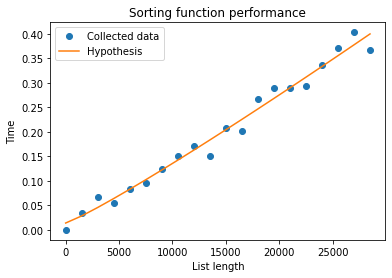

In [31]:
plot_data(*data, function=f_fit)

It seems that hypothesis was **correct**. We see a satisfying curve fit for this function.

### Prediction

Let us try predictions for sizes $n_1=30000$ and $n_2=32000$.

In [32]:
n1 = int(1e5)
n2 = int(2e5)

For $f(n_1)$:

In [33]:
f_fit(n1)

1.5317410041157995

And for $f(n_2)$:

In [34]:
f_fit(n2)

3.2321765593582397

### Verification

Now, we have got measured times for real `sort_list` algorithm:

In [35]:
time_check(n1)

1.5040969848632812

In [36]:
time_check(n2)

3.347522258758545

Viewing the results on my device I can claim that they actulally fit very well.

### Results

We clearly see that for greater values the assumption is good.

So, `sort_list` has **$O(n \log(n))$ time complexity** indeed.

## Presentation

Pure *binary heap* usage:

Adding new elements.

In [37]:
bh = BinHeap()
bh.insert(8)
bh.insert(9)
bh.insert(2)
bh.insert(3)
bh.insert(5)

In [38]:
print(bh)

[9, 8, 2, 3, 5]


Popping the root - maximal value.

In [39]:
bh.pop_max()

9

In [40]:
print(bh)

[8, 5, 2, 3]


And the most important - sorting.

In [41]:
sort_list([10, 2, 50, 4, 10, 44])

[50, 44, 10, 10, 4, 2]

In [42]:
sort_list([-4, 50, 3.5, 18, 6])

[50, 18, 6, 3.5, -4]

-----------------------

# Task 3

_**Binary heap with a limited size**_

**NOTE**: This is not the only way to do this task and in case of *building* there are more efficient ones. However, some steps are done on purpose - to show the structure.

-----------------------

This time I use *Max-Heap* again. Not to repeat the same code, I create a inheriting class and adjust necessary things.

I overload the addition methods.

- Insertion can be done in the standard way when there is any space left. Otherwise the maximal element is replaced with new one and we are swapping it downwards.

- In case of list building, after creating an ordered heap, we pop the redundant maximal elements - until the size is right.

In [43]:
class LimBinHeap(BinHeap):
    """Max Binary heap but keeping only some number of most relevant (minimal) numbers."""

    def __init__(self, max_size: int):
        """Create an empty heap and set its maximal size.

        Args:
            max_size (int): Maximal size.
        """
        super().__init__()
        self.max_size = max_size

    def _is_full(self) -> bool:
        """A helper function.
        Tell whether the heap is filled
        (has a maximal allowed number of elements).

        Returns:
            bool: Info about being filled.
        """
        return self.size == self.max_size

    def _is_overfilled(self) -> bool:
        """A helper function.
        Tell whether the heap is temporarily overfilled
        (has more elements than allowed).

        Returns:
            bool: Info about being overfilled.
        """
        return self.size > self.max_size

    def insert(self, value: float):
        """Insert a value in the given place (index).
        Preserve the right elements order and structure.
        Delete redundant elements if needed.

        Args:
            value (float): Value to insert.
        Raises:
            TypeError: Raised when value to insert is not numeric.
        """

        if self._is_full():
            if not (isinstance(value, float) or isinstance(value, int)):
                raise TypeError("Values have to be numbers.")
            if value < self.find_max():
                self.heap_list[1] = value
                self._perc_down(1)
        else:
            super().insert(value)

    def build_heap(self, alist: List[float]):
        """Build an ordered binary heap from list.
        Delete redundant elements if needed and keep the maximal size.

        Args:
            alist (List[float]): List of values to build a heap from.

        Raises:
            TypeError: List on input have to contain only numeric values.
        """
        super().build_heap(alist)
        while self._is_overfilled():
            self.pop_max()

## Presentation

There we see how the heap keeps only limited set of minimal values.

In [44]:
bh_l = LimBinHeap(10)
bh_l.build_heap([8, 7, 2, 6, 4.5, 1, 0, 5.5, 5.6, 0, 4.3, 0.5, 0.3, 0, 0, 5])
print(bh_l)

[4.5, 4.3, 2, 0.3, 0.5, 1, 0, 0, 0, 0]


After insertions it preserves the proper structure and size.

In [45]:
bh_l.insert(50)
bh_l.insert(-8)
bh_l.insert(9)
bh_l.insert(4)

In [46]:
print(bh_l)

[4, 0.5, 2, 0.3, 0, 1, 0, 0, 0, -8]


-----------------------

# Task 4

_**Derivation for a given formula**_

-----------------------

## Features

I am going to implement a set of functions allowing ultimately to find the derivative of any typed function which satisfises the following conditions:

As an input there are allowed all combinations (nestings) of the functions below: 
- standard arithmetic operators: $f+g,\;f-g,\;f\cdot g,\;\frac{f}{g},\;f^g$, but also $\sqrt{f}$ - as the only explicit root;
- logarithm: $\ln(f)$; other logarithms can be gained by division;
- exponential function as $\exp(f)$;
- trigonometric functions: $\sin(f),\;\cos(f),\;\tan(f),\;\cot(f)$;
- inverse trigonometric functions: $\arcsin(f),\;\arccos(f),\;\arctan(f),\;\mathrm{arccot}(f)$.

The allowed values in functions are *numbers* (rational can be given by division) and *latin letters*.

There are the function dictionaries giving the names along with priority value. In addition to that, sets defining letters and digits (together with the *point*).

In [47]:
opers = {"+": 3, "-": 3, "*": 2, "/": 2, "^": 1}
one_arg_fncts = {
    "sqrt": 0,
    "ln": 0,
    "exp": 0,
    "sin": 0,
    "cos": 0,
    "tan": 0,
    "cot": 0,
    "arcsin": 0,
    "arccos": 0,
    "arctan": 0,
    "arccot": 0,
}
parenth = {"(": 4, ")": 4}

In [48]:
letters = set(string.ascii_lowercase).union(set(string.ascii_uppercase)).union({"pi"})
digits = set(string.digits).union({".", "-"})

## Preparation

### Formula processing

For future number syntax validation I need a proper tool: 

In [49]:
def number_validate(numbers: list) -> bool:
    """Check if the list of succeeding characters can represent any number.

    Args:
        numbers (list): List of characters.

    Returns:
        bool: Info about being a number representation.
    """
    for numb in numbers:
        if numb.count(".") > 1:
            return False

        numb_digits = list(numb)
        if numb_digits[0] == "." or numb_digits[-1] == ".":
            return False

        if len(numb) > 1:
            if numb_digits[0] == "0" and numb_digits[1] != ".":
                return False
    return True

So, the first step after reading a string with some expression is to parse this expression.

In [50]:
def formula_parse(expression: str) -> List[str]:
    """Split the string nmathematical expression into list of numbers, operators, functions, parenthesis and letter-symbols.

    Args:
        expression (str): String mathematical formula.

    Raises:
        ValueError: Raised when the symbols in the formula are neither alphanumeric nor represent operators.
        Exception: Expression cannot be empty to parse it.

    Returns:
        List[str]: Expression splitted into basic components in the original order.
    """
    char_list = list(expression)
    comps = []
    functs = set({**opers, **one_arg_fncts, **parenth}.keys())
    for name in sorted(functs.union(letters), key=len, reverse=True):
        can_find = True
        name_len = len(name)
        while can_find:
            try:
                occur_ind = "".join(char_list).index(name)
                char_list[occur_ind : occur_ind + name_len] = [" "] * name_len
                comps.append((occur_ind, name))
            except ValueError:
                can_find = False

    if not all([_ in digits.union(" ") for _ in char_list]):
        raise ValueError("Some characters in the expression are not allowed.")

    numbers = "".join(char_list).split()

    if not number_validate(numbers):
        raise ValueError("Some numbers in the expression are not correct.")

    for numb in numbers:
        occur_ind = "".join(char_list).index(numb)
        char_list[occur_ind : occur_ind + name_len] = [" "] * name_len
        comps.append((occur_ind, numb))

    result = [None] * len(expression)
    comps_dict = dict(comps)
    for ind in sorted(comps_dict):
        result[ind] = comps_dict[ind]
    result = list(filter(None, result))
    if result:
        return result
    else:
        raise Exception("There is no expression to parse.")

Next, we can add missing multiplication symbols and on the fly investigate formulas syntax (its part regarding symbols closest neighborhood). 

In [51]:
def formula_fill(parsed_formula: List[str]) -> List[str]:
    """Add the implicit symbols as multiplication to the expression component list.
    Take care also about minuses. On the fly find syntax errors regarding the symbol neighboring rules.

    Args:
        parsed_formula (List[str]): List of formula elements in the original order.

    Raises:
        ValueError: Raised when a symbol is next to another making expression rationally wrong.

    Returns:
        List[str]: List of components in original order with implicit operators added.
    """
    filled_formula = parsed_formula[:]

    def eval_type(comp):
        if comp == "-":
            return "m"
        elif comp in opers:
            return "o"
        elif comp in one_arg_fncts:
            return "1a"
        elif comp == "(":
            return "p_o"
        elif comp == ")":
            return "p_c"
        elif comp in letters:
            return "l"
        else:
            return "n"

    comp_types = [eval_type(comp) for comp in parsed_formula]
    prev_comp_type = ""
    prev_prev_comp_type = ""
    mul_to_insert = []
    min_to_insert = []

    for ind, comp_type in enumerate(comp_types):

        if prev_comp_type in {"p_c", "l", "n"} and comp_type in {"1a", "p_o", "l", "n"}:
            mul_to_insert.append(ind)
        if prev_comp_type in {"o", "p_o", "1a", "m"} and comp_type in {"o", "p_c"}:
            raise ValueError("Expression is inappropriate.")
        if prev_comp_type in {"o", "1a", "m"} and comp_type == "m":
            raise ValueError("Expression is inappropriate.")
        if (
            prev_comp_type == "m"
            and comp_type in {"1a", "p_o", "l", "n"}
            and (ind == 1 or prev_prev_comp_type == "p_o")
        ):
            min_to_insert.append(ind)
        prev_prev_comp_type = prev_comp_type
        prev_comp_type = comp_type

    for ind in sorted(mul_to_insert + min_to_insert, reverse=True):
        filled_formula.insert(ind, "*")
        if ind in min_to_insert:
            filled_formula[ind - 1] = -1

    return filled_formula

Then we can move on to changing the notation system. I will be using the *stack* class from the lecture [[5]](#ref5). 

In [52]:
class Stack:
    """Basic stack. Uses a python list to keep elements."""

    def __init__(self):
        """Create an empty stack."""
        self.items = []

    def is_empty(self) -> bool:
        """Check if the stack is empty.

        Returns:
            bool: Info about an emptiness.
        """
        return self.items == []

    def push(self, item: Any):
        """Add an item on the top of the stack.

        Args:
            item (Any): Item to be added.
        """
        self.items.append(item)

    def pop(self) -> Any:
        """Remove an item from the top of the stack and show it.

        Returns:
            Any: Item to be taken.
        """
        return self.items.pop()

    def peek(self) -> Any:
        """Show the item on the top but not remove it.

        Returns:
            Any: The top item.
        """
        return self.items[len(self.items) - 1]

    def size(self) -> int:
        """Check the size of the stack - its height.

        Returns:
            int: Stack height.
        """
        return len(self.items)

To avoid future issues, we check parentheses correctness.

In [53]:
def parenth_checker(symbol_list: List[str]) -> bool:
    """Validate parenthesis balance in the formula.

    Args:
        symbol_list (List[str]): List of formula components the in original order.

    Returns:
        bool: Info about correct parentesis balance.
    """
    stack = Stack()
    balanced = True
    ind = 0
    while ind < len(symbol_list) and balanced:
        symbol = symbol_list[ind]
        if symbol == "(":
            stack.push(symbol)
        elif symbol == ")":
            if stack.is_empty():
                balanced = False
            else:
                stack.pop()
        ind += 1

    if balanced and stack.is_empty():
        return True
    else:
        return False

At this point, a little helper function to tell whether string has a float representation. 

In [54]:
def is_float(expr: str) -> bool:
    """Check if the text represents some number.

    Args:
        expr (str): Some text to be checked.

    Returns:
        bool: Info about being a number representation.
    """
    try:
        float(expr)
        return True
    except ValueError:
        return False

Finally, transforming a prepared list into a sequence in *postfix notation*.

In [55]:
def list_to_postfix(expr_list: List[str]) -> List[str]:
    """Change the notation to postfix.
    One argument functions are getting their one argument, operators - two of them.
    Leave (unneeded) parentheses.

    Args:
        expr_list (List[str]): List of components in original order (filled to be explicit).

    Returns:
        List[str]: Postorder notation of the list on input.
    """
    prior_dict = {**opers, **one_arg_fncts, **parenth}
    stack = Stack()
    posfix_list = []
    comp_list = expr_list

    for comp in comp_list:
        if comp in letters or is_float(comp):
            posfix_list.append(comp)
        elif comp == "(":
            stack.push(comp)
        elif comp == ")":
            top_comp = stack.pop()
            while top_comp != "(":
                posfix_list.append(top_comp)
                top_comp = stack.pop()
        else:
            while (not stack.is_empty()) and (
                prior_dict[stack.peek()] <= prior_dict[comp]
            ):
                posfix_list.append(stack.pop())
            stack.push(comp)

    while not stack.is_empty():
        posfix_list.append(stack.pop())
    return posfix_list

All this steps can be done with the help of the function below:

In [56]:
def postfix_formula(expression: str) -> List[str]:
    """Transform a sting into an easy to process postfix list of components.

    Args:
        expression (str): Mathemetical expression as a text.

    Raises:
        Exception: Parentheses have to be balanced.

    Returns:
        List[str]: Postorder notation of the expression (as a list of components).
    """
    parsed = formula_parse(expression)
    filled = formula_fill(parsed)
    if parenth_checker(filled):
        return list_to_postfix(filled)
    else:
        raise Exception("Parentheses not balances.")

### Building a tree

A simple tree can be created only using basic *node* objects with keys and referencing its children. 

In [57]:
class FormulaNode:
    """Node in formula tree.
    Represents an operator, function or value.
    Value means a number, a letter parameter or a letter variable.
    """

    def __init__(
        self, key: str, left_ch: FormulaNode = None, right_ch: FormulaNode = None
    ):
        """Create a node represention of expression component.
        Functions have only right child - their argument.
        Operators' children are the left and right operands.
        Values cannot have children.

        Args:
            key (str): Symbol of the node (value, function or operator).
            left_ch (FormulaNode, optional): Left child in the tree structure. Defaults to None.
            right_ch (FormulaNode, optional: Right child in the tree structure. Defaults to None.
        """
        self.key = key
        self.left_ch = left_ch
        self.right_ch = right_ch

    def repl_data(self, node: FormulaNode):
        """Change the nodes data - key and children.

        Args:
            node (FormulaNode): Node to get the data from.
        """
        self.key = node.key
        self.left_ch, self.right_ch = node.left_ch, node.right_ch

Therefore, I implement something what can easily extract a tree from a *parsed, postfix formula*.

Optional argument `replace_fncts` can be given to change some letters for real functions. It is not used in basic formula transformation, but is really handy during the recursive derivation process (later).

In [58]:
def tree_from_formula(
    postfix_formula: List[str], replace_fncts: dict = dict()
) -> FormulaNode:
    """Transform a list of components in postfix notation to the tree representation.
    Some symbols can be possibly replaced by a real functions or something else.

    Args:
        postfix_formula (List[str]): List of components in postfix notation.
        replace_fncts (dict, optional): Symbols to replace. Defaults to dict().

    Returns:
        FormulaNode: Root node of the expression tree.
    """
    stack = Stack()
    ind = 0

    def leaf_nodif(key: Union[FormulaNode, float]):
        if not isinstance(key, FormulaNode):
            return FormulaNode(key)
        else:
            return key

    while ind < len(postfix_formula):
        comp = postfix_formula[ind]

        # optional replacing
        if comp in replace_fncts:
            comp = replace_fncts[comp]

        if comp in opers:
            right_ch = stack.pop()
            left_ch = stack.pop()
            new_node = FormulaNode(comp, left_ch, right_ch)
            stack.push(new_node)
        elif comp in one_arg_fncts:
            child = stack.pop()
            new_node = FormulaNode(comp, right_ch=child)
            stack.push(new_node)
        else:
            comp = leaf_nodif(comp)
            stack.push(comp)
        ind += 1
    root = stack.pop()
    return root

This can also help to build derivative trees only from the written formulas.

Ultimately - tree from text.

In [59]:
def get_tree(expression: str, replace_fncts=dict()) -> FormulaNode:
    """Transform a sting into a tree representation.

    Args:
        expression (str): Mathemetical expression as a text.
        replace_fncts ([type], optional): Symbols to replace by something else. Defaults to dict().

    Returns:
        FormulaNode: Root node of the expression tree.
    """
    pf_formula = postfix_formula(expression)
    return tree_from_formula(pf_formula, replace_fncts)

## Derivation

In this step I begin with creating derivation formula tables [[6]](#ref6). They consider almost all the combinations with these functions.

It is also worth mentioning that *power* function has a quite general derivative there to handle also $f(x)^{g(x)}$. That is why

$$\frac{d}{dx}f^g = f^g (\frac{gf'}{f}+g'\ln(f)).$$

That is for $x^a$ and $a^x$ too. Fortunately, the formula above implies well known particular formulas.

In my notation, for each function $f$ and $g$, these are `f` and `g`. However, even though it might be not intuitive, $f'$ becomes `F` and the same with $g'$ - `G`.

In [60]:
deriv_formulas_oper = {
    "+": "F+G",
    "-": "F-G",
    "*": "Fg+fG",
    "/": "(Fg-fG)/g^2",
    "^": "f^g(gF/f+Glnf)",
}
deriv_formulas_oaf = {
    "sqrt": "F/(2sqrtf)",
    "ln": "F/f",
    "exp": "Fe^f",
    "sin": "Fcosf",
    "cos": "-Fsinf",
    "tan": "(1+tanf^2)F",
    "cot": "(-1-cotf^2)F",
    "arcsin": "F/sqrt(1-f^2)",
    "arccos": "-F/sqrt(1-f^2)",
    "arctan": "F/(1+f^2)",
    "arccot": "-F/(1+f^2)",
}

Main function is here below. It works recursively for branches and always decide whish formula to use, plus what is the current substitution for `f`, `g` and its derivatives. 

Moreover it uses *two-children* substitution or *one-children* version, depending on the input - whether we have got a arithmetic operator or one-argument function.

In [61]:
def derivative(formula_tree: FormulaNode, variable: str) -> FormulaNode:
    """Change the function tree into its derivative tree.

    Args:
        formula_tree (FormulaNode): Tree of a function to derivate.
        variable (str): Variable with respect to which we derivate.

    Raises:
        ValueError: If given variable is not a letter of is a special letter.
        Exception: When something does not work - for developement.

    Returns:
        FormulaNode: Tree of the function after derivation.
    """
    if variable not in letters or variable in {"e", "pi"}:
        raise ValueError("Variable name is not correct.")

    def fnct_replacings(double_args: bool = True):
        if double_args:
            repl_dict = {
                "F": derivative(formula_tree.left_ch, variable),
                "G": derivative(formula_tree.right_ch, variable),
                "f": formula_tree.left_ch,
                "g": formula_tree.right_ch,
            }
        else:
            repl_dict = {
                "F": derivative(formula_tree.right_ch, variable),
                "f": formula_tree.right_ch,
            }
        return repl_dict

    comp = formula_tree.key
    if comp == variable:
        return get_tree("1")
    elif is_float(comp) or comp in letters:
        return get_tree("0")
    elif comp in deriv_formulas_oper:
        return get_tree(deriv_formulas_oper[comp], fnct_replacings())
    elif comp in deriv_formulas_oaf:
        return get_tree(deriv_formulas_oaf[comp], fnct_replacings(False))
    else:
        raise Exception("Unknown derivation error.")

## Returning to the expression

Now, I carry out a really basic simpification for a tree. I do it with the help of "*postorder* approach".

Obviously, **it can be way more improved**, but I belive this is not the main goal now.

Things to be added are possibly:

- fraction (`a / b`) reducing
- evaluating the ultimate value for chains of operations with the same priority
- changing the power if the expression is multiplied by itself

and so on.

In [62]:
def tree_simplif(node: FormulaNode):
    """Do the really basic simplification.
    Reduce fragments with 1 and 0 operations and can be immediatly simpler.
    Execute the obvious operations too.

    Args:
        node (FormulaNode): Root node of a tree to simplify.

    Raises:
        ValueError: If the division by 0 is picked.
    """
    aritm_opers_d = {
        "+": lambda a, b: operator.add(a, b),
        "-": lambda a, b: operator.sub(a, b),
        "*": lambda a, b: operator.mul(a, b),
        # no truediv to keep rational numbers as they were
        "^": lambda a, b: operator.pow(a, b),
    }

    if node:
        tree_simplif(node.right_ch)
        tree_simplif(node.left_ch)

        if node.key == "*" and (node.left_ch.key == "0" or node.right_ch.key == "0"):
            node.repl_data(FormulaNode("0"))
        elif node.key == "*" and node.left_ch.key == "1":
            node.repl_data(node.right_ch)
        elif node.key == "*" and node.right_ch.key == "1":
            node.repl_data(node.left_ch)
        elif node.key == "+" and node.right_ch.key == "0":
            node.repl_data(node.left_ch)
        elif node.key == "+" and node.left_ch.key == "0":
            node.repl_data(node.right_ch)
        elif node.key == "-" and node.right_ch.key == "0":
            node.repl_data(node.left_ch)
        elif node.key == "-" and node.left_ch.key == "0":
            new_node = FormulaNode("*", FormulaNode("-1"), node.right_ch)
            node.repl_data(new_node)
        elif node.key == "^" and node.left_ch.key == "0":
            node.repl_data(FormulaNode("0"))
        elif node.key == "^" and node.left_ch.key == "1":
            node.repl_data(FormulaNode("1"))
        elif node.key == "^" and node.right_ch.key == "0":
            node.repl_data(FormulaNode("1"))
        elif node.key == "^" and node.right_ch.key == "1":
            node.repl_data(node.left_ch)
        elif node.key == "/" and node.right_ch.key == "0":
            raise ValueError("Cannot divide by 0.")
        elif node.key == "/" and node.right_ch.key == "1":
            node.repl_data(node.left_ch)
        elif node.key == "/" and node.left_ch.key == "0":
            node.repl_data(FormulaNode("0"))
        elif node.key == "ln" and node.right_ch.key == "e":
            node.repl_data(FormulaNode("1"))
        elif node.key == "ln" and node.right_ch.key == "1":
            node.repl_data(FormulaNode("0"))

        elif (
            node.key in aritm_opers_d
            and is_float(node.left_ch.key)
            and is_float(node.right_ch.key)
        ):
            result = aritm_opers_d[node.key](
                float(node.left_ch.key), float(node.right_ch.key)
            )
            if not result % 1:
                result = int(result)
            node.repl_data(FormulaNode(str(result)))

Using the standard *inorder* algorithm I come back from tree to the right expression. It is "hyper-correct" version expression actually, but that is even better.

In [63]:
def formula_from_tree(root: FormulaNode) -> str:
    """Change the tree back to its text representation.
    Use the inorder traversal.

    Args:
        root (FormulaNode): Root of the tree to transform.

    Returns:
        str: Expression string representation.
    """
    expr_list = []

    def inorder(node):
        if node:
            if node.left_ch or node.right_ch:
                expr_list.append("(")
            inorder(node.left_ch)
            expr_list.append(node.key)
            inorder(node.right_ch)
            if node.left_ch or node.right_ch:
                expr_list.append(")")

    inorder(root)
    return "".join(map(str, expr_list))

## Final tool

A function collecting all the tools written in this task. It takes a string expression on input and outputs simplified string derivative.

In [64]:
def derivative_str(expression: str, variable: str) -> str:
    """Derivate taking the text expression and return it in the same form.
    Do the basic simplifications.

    Args:
        expression (str): Formula as text.
        variable (str): Variable with respect to which we derivate.

    Returns:
        str: Derivative as a text expression.
    """
    expr_tr = get_tree(expression)
    tree_simplif(expr_tr)
    deriv_tr = derivative(expr_tr, variable)
    tree_simplif(deriv_tr)
    result = formula_from_tree(deriv_tr)
    return result

## Presentation

Some examples of derivatives.

In [65]:
try:
    derivative_str("4+4", "4")
except ValueError as err:
    print(err)

Variable name is not correct.


In [66]:
derivative_str("5s+6", "x")

'0'

In [67]:
derivative_str("lnx", "x")

'(1/x)'

In [68]:
derivative_str("5s+6", "s")

'5'

In [69]:
derivative_str("sin(pi x)", "x")

'(pi*(cos(pi*x)))'

In [70]:
# correct but might be suprising (it is due to the general formula usage)
derivative_str("5x^2+6", "x")

'(5*((x^2)*(2/x)))'

In [71]:
derivative_str("lnx/sinx", "x")

'((((1/x)*(sinx))-((lnx)*(cosx)))/((sinx)^2))'

-----------------------

<a id="ref1">[1]</a> J. Szwabiński, *Wykład 9 - Drzewa i algorytmy ich przetwarzania (ciąg dalszy)*,  *Algorytmy i struktury danych*, p. 2-16. [accessed: 08.01.2022]. Link: http://prac.im.pwr.wroc.pl/~szwabin/assets/algo/lectures/9.pdf.

<a id="ref2">[2]</a> M. Hofri; H. Mahmoud, *Algorithmics of Nonuniformity: Tools and Paradigms*, 2019, p. 261.

<a id="ref3">[3]</a> J. Szwabiński, *Wykład 8 - Drzewa i algorytmy ich przetwarzania*,  *Algorytmy i struktury danych*, p. 17-24. [accessed: 08.01.2022]. Link: http://prac.im.pwr.wroc.pl/~szwabin/assets/algo/lectures/9.pdf.

<a id="ref4">[4]</a> File *"lista5_machaj.ipynb"* was sent as a task via email. It <u>might</u> be also posted on my *GitHub*. Link: https://github.com/o-mateo-o.

<a id="ref5">[5]</a> J. Szwabiński, *Wykłady 2 i 3 - Abstrakcyjne struktury danych*,  *Algorytmy i struktury danych*, p. 6-17. [accessed: 08.01.2022]. Link: http://prac.im.pwr.wroc.pl/~szwabin/assets/algo/lectures/2.pdf.


<a id="ref6">[6]</a> *Tablica pochodnych funkcji elementarnych*; *Wzory o pochodnej funkcji*, GiS Wrocław, [accessed: 08.01.2022]. Link: http://www.gis.wroc.pl/pdf/pochodne.pdf.